In [1]:
import glob
import numpy as np
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC, SVC
import time
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

%matplotlib inline



In [10]:
#loading all training data vehicle and non vehicle by using glob module

non_vehicle_paths = ["data/non-vehicles/Extras/*.png", "data/non-vehicles/GTI/*.png"]

vehicle_paths = ["data/vehicles/GTI_Far/*.png", "data/vehicles/GTI_Left/*.png", "data/vehicles/GTI_Right/*.png",
                    "data/vehicles/GTI_MiddleClose/*.png", "data/vehicles/KITTI_extracted/*.png"]

non_vehicle_filenames = []

vehicle_filenames = []

for path in non_vehicle_paths:
    non_vehicle_filenames += glob.glob(path)
    
for path in vehicle_paths:
    vehicle_filenames += glob.glob(path)
    
print('Number of Car samples : {}'.format(len(vehicle_filenames)))
print('Number of not car samples : {}'.format(len(non_vehicle_filenames)))

Number of Car samples : 8792
Number of not car samples : 8968


In [81]:
def plot_images(image, title, cmap, x, y):
    f,ax=plt.subplots(x,y,figsize=(6*y, 9*x))
    f.tight_layout()
    if( x == 1 ):
        if y == 1:
            ax.imshow(image[y-1],cmap=cmap[y-1])
            ax.set_title(title[y-1], fontsize=30)
        else: 
            for j in range(0,y):
                ax[j].imshow(image[j],cmap=cmap[j])
                ax[j].set_title(title[j], fontsize=30)
    else:
        for i in range(0,x):
            if y == 1:
                ax[i].imshow(image[i],cmap=cmap[i])
                ax[i].set_title(title[i], fontsize=30)
            else:
                for j in range(0,y):
                    ax[i][j].imshow(image[i*y+j],cmap=cmap[i*y+j])
                    ax[i][j].set_title(title[i*y+j], fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

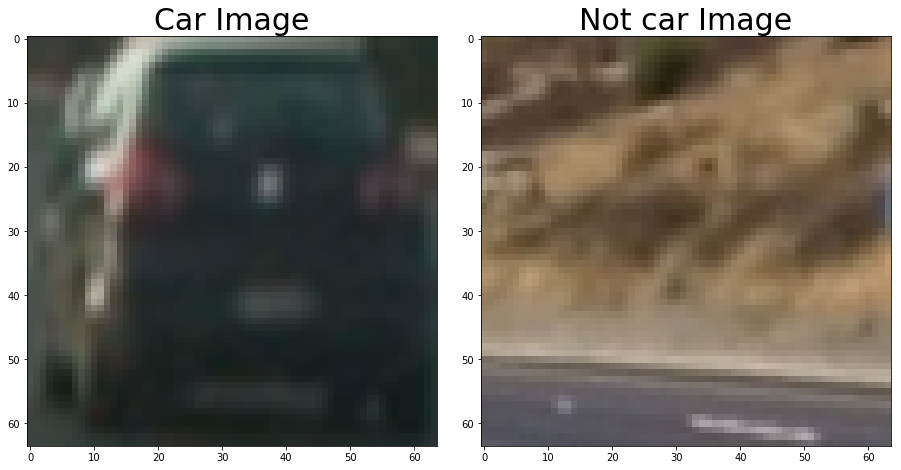

In [4]:
vehicle_image = mpimg.imread(vehicle_filenames[520])
non_vehicle_image = mpimg.imread(non_vehicle_filenames[520])

image = [vehicle_image, non_vehicle_image]
title = ['Car Image', 'Not car Image']
cmap = ['RdBu', 'RdBu']
plot_images(image, title, cmap, 1, 2)

In [5]:
#function to get raw pixel image features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#function to get color histogram beans
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    img = img*255
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#function to extract HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
#function to extract features based on parameters for single image
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channels=[0],
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range = hist_range)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = []
        for channel in hog_channels:
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)   
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

#function to extract features for all the image name passed
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channels=[0], spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    for img in imgs:
        image = mpimg.imread(img)
        image_features = single_img_features(image, cspace=cspace, spatial_size = spatial_size,
                                             hist_bins = hist_bins, hist_range = hist_range,
                                             orient = orient, pix_per_cell = pix_per_cell,
                                             cell_per_block = cell_per_block, hog_channels = hog_channels,
                                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)        
        # Append the new feature vector to the features list
        features.append(image_features)
    return features
    

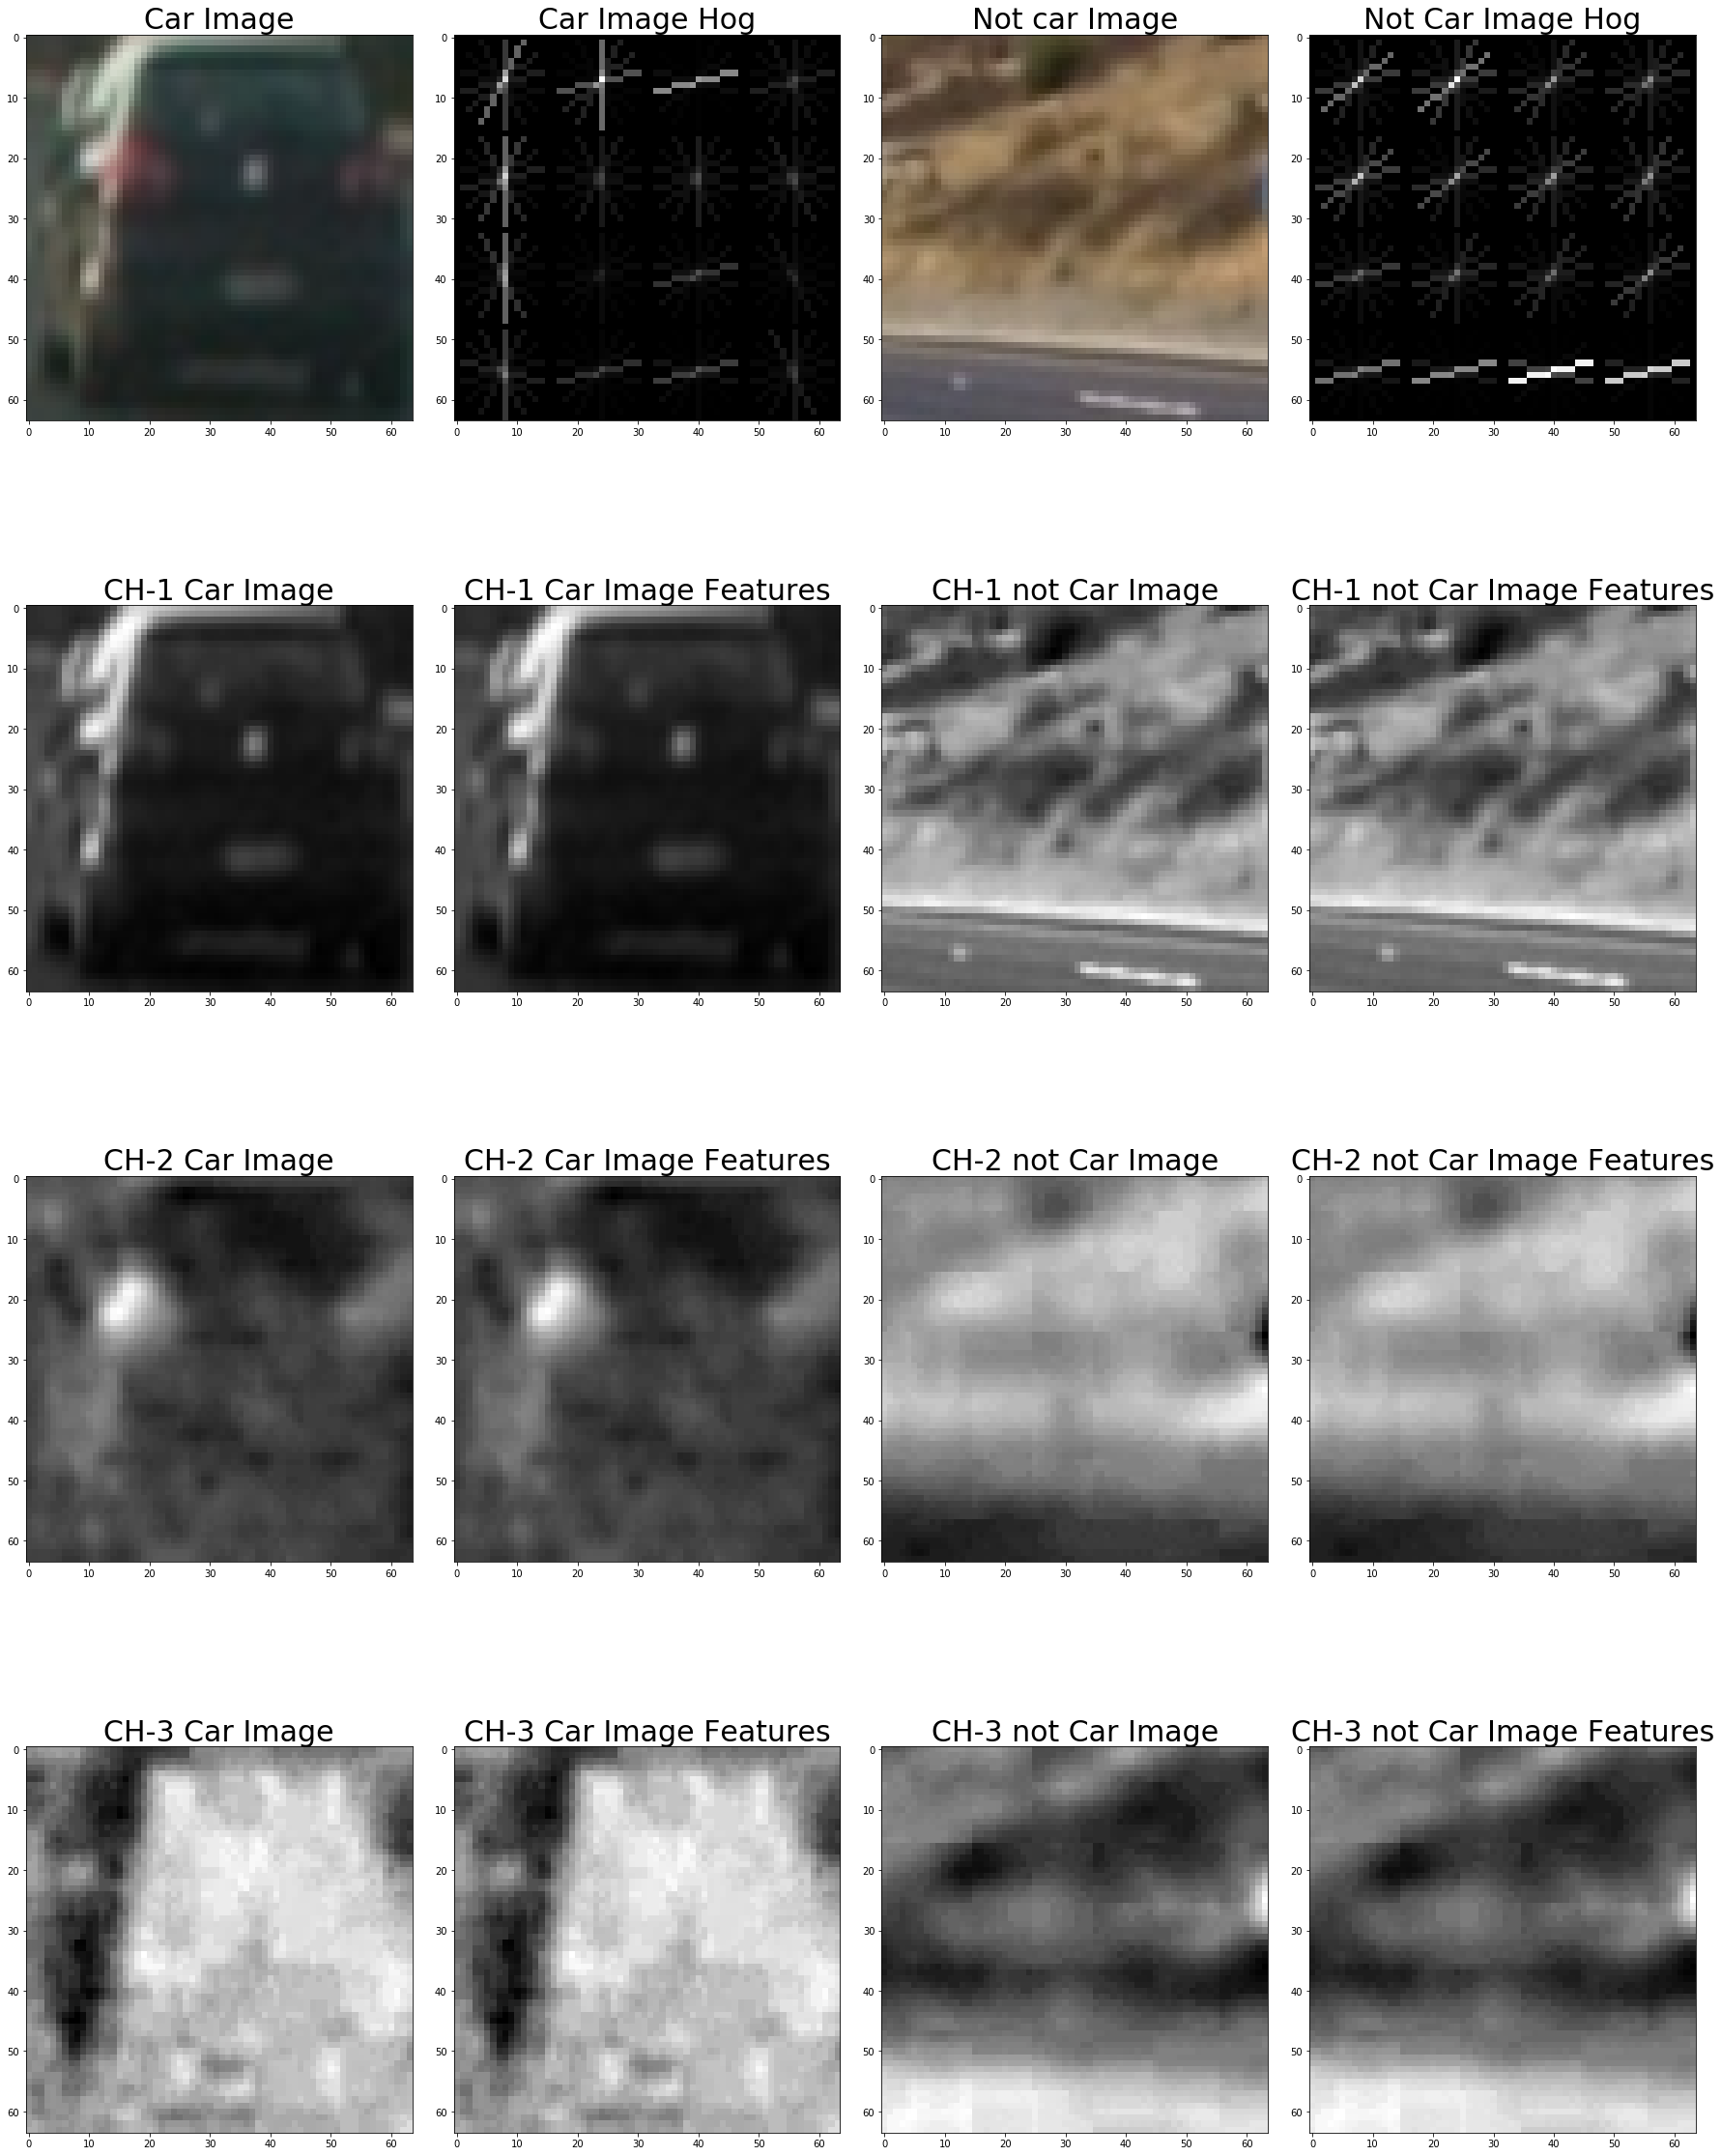

In [6]:
veh_image = np.copy(vehicle_image)
nveh_image = np.copy(non_vehicle_image)
vehicle_image = cv2.cvtColor(vehicle_image, cv2.COLOR_RGB2YUV)
non_vehicle_image = cv2.cvtColor(non_vehicle_image, cv2.COLOR_RGB2YUV)
vehicle_image_hog = get_hog_features(vehicle_image[:,:,0], 7, 16, 2, 
                        vis=True, feature_vec=True)

non_vehicle_image_hog = get_hog_features(non_vehicle_image[:,:,0], 7, 16, 2, 
                        vis=True, feature_vec=True)

image = [veh_image, vehicle_image_hog[1], nveh_image, non_vehicle_image_hog[1],
        vehicle_image[:,:,0], vehicle_image[:,:,0], non_vehicle_image[:,:,0], non_vehicle_image[:,:,0],
        vehicle_image[:,:,1], vehicle_image[:,:,1], non_vehicle_image[:,:,1], non_vehicle_image[:,:,1],
        vehicle_image[:,:,2], vehicle_image[:,:,2], non_vehicle_image[:,:,2], non_vehicle_image[:,:,2]]
title = ['Car Image', 'Car Image Hog', 'Not car Image', 'Not Car Image Hog', 
        'CH-1 Car Image', 'CH-1 Car Image Features', 'CH-1 not Car Image', 'CH-1 not Car Image Features', 
        'CH-2 Car Image', 'CH-2 Car Image Features', 'CH-2 not Car Image', 'CH-2 not Car Image Features', 
        'CH-3 Car Image', 'CH-3 Car Image Features', 'CH-3 not Car Image', 'CH-3 not Car Image Features', ]
cmap = ['RdBu', 'gray', 'RdBu', 'gray','gray','gray','gray','gray','gray','gray','gray','gray','gray','gray','gray','gray']

plot_images(image,title,cmap,4,4)


In [7]:
#setting up all the parameters and extracting features for can and noncar images

colorspace = 'YUV'
orient = 7
pix_per_cell = 16
cell_per_block = 2
hog_channel = [0]
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
spatial_feat = True
hist_feat = True
hog_feat = True


car_features = extract_features(vehicle_filenames, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channels=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_filenames, cspace=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channels=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

In [8]:
#stacking car and noncar features and assigning corresponding labels in y

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Number of features : {}'.format(X.shape[1]))

Number of features : 1116


In [12]:
rand_state = np.random.randint(0, 100)
#spliting features in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)


In [13]:
# Fitting and normalizing training and testing data

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [14]:
#training SVM with 'rbf' kernel

t=time.time()
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
t2 = time.time()
print("Training Time : {}".format(t2-t))
print("Accuracy : {}".format(acc))

Training Time 71.76956009864807: 
Accuracy : 0.9907094594594594


In [15]:
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channels=[0], spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=cspace, spatial_size = spatial_size,
                                             hist_bins = hist_bins, hist_range = hist_range,
                                             orient = orient, pix_per_cell = pix_per_cell,
                                             cell_per_block = cell_per_block, hog_channels = hog_channels,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [16]:
#function to generate sliding windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [17]:

# function to add heat to identified windows
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Function for applying threshold of minimum number of overlapping identified windows
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#function to draw boxes on identified labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        x_len = np.max(nonzerox) - np.min(nonzerox)
        y_len = np.max(nonzeroy) - np.min(nonzeroy)
           
        if x_len > 40 and y_len > 40:
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [85]:
# class containing pipeline

class VehicleDetector(object):
    
    previous_ten_heatmap = []
    
    def __init__(self):
      self.previous_ten_heatmap = []
    
    def pipeline(self, image):
        #defining initial parameters
        colorspace = 'YUV' 
        orient = 7
        pix_per_cell = 16
        cell_per_block = 2
        hog_channel = [0]
        spatial_size = (16, 16)
        hist_bins = 32
        hist_range = (0, 256)
        spatial_feat = True
        hist_feat = True
        hog_feat = True


        draw_image = np.copy(image)


        image = image.astype(np.float32)/255

        window_dimensions = [[[80, 80],[400, 550]],
                             [[64, 64],[400, 500]],
                             [[96, 128],[400, 600]]]
        windows= []

        for dimension in window_dimensions:
            windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=dimension[1], 
                            xy_window=dimension[0], xy_overlap=(0.5, 0.5)))


        hot_windows = search_windows(image, windows, clf, X_scaler, cspace=colorspace, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channels=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat,hot_windows)
        heat = apply_threshold(heat,1)
        heatmap = np.clip(heat, 0, 255)
        if(len(self.previous_ten_heatmap)>5):
            self.previous_ten_heatmap = self.previous_ten_heatmap[1:]
        self.previous_ten_heatmap.append(heatmap)
        # Find final boxes from heatmap using label function
        labels = label(np.mean(self.previous_ten_heatmap, axis=0))
        dr_img = draw_labeled_bboxes(np.copy(draw_image), labels)
        return dr_img.astype(np.uint8)


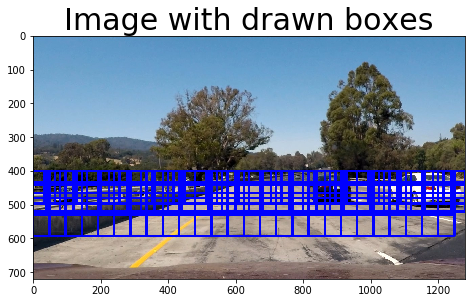

In [40]:
image = mpimg.imread('test_images/test1.jpg')
window_dimensions = [[[80, 80],[400, 550]],
                             [[64, 64],[400, 500]],
                             [[96, 128],[400, 600]]]
windows= []
for dimension in window_dimensions:
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=dimension[1], 
                    xy_window=dimension[0], xy_overlap=(0.5, 0.5)))
    

plot_images([draw_boxes(image, windows)], ['Image with drawn boxes'], ['RdBu'], 1 , 1)



In [69]:
test_images_path = glob.glob('test_images/*.jpg')
colorspace = 'YUV' 
orient = 7
pix_per_cell = 16
cell_per_block = 2
hog_channel = [0]
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
spatial_feat = True
hist_feat = True
hog_feat = True
titles = []
img_hot_windows = []
for path in test_images_path:
    img = mpimg.imread(path)
    img_scaled = img.astype(np.float32)/255
    hot_windows = search_windows(img_scaled, windows, clf, X_scaler, cspace=colorspace, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channels=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    img_hot_windows.append([img, hot_windows])
    titles.append('Image : '+path.split('\\')[1].split('.')[0])


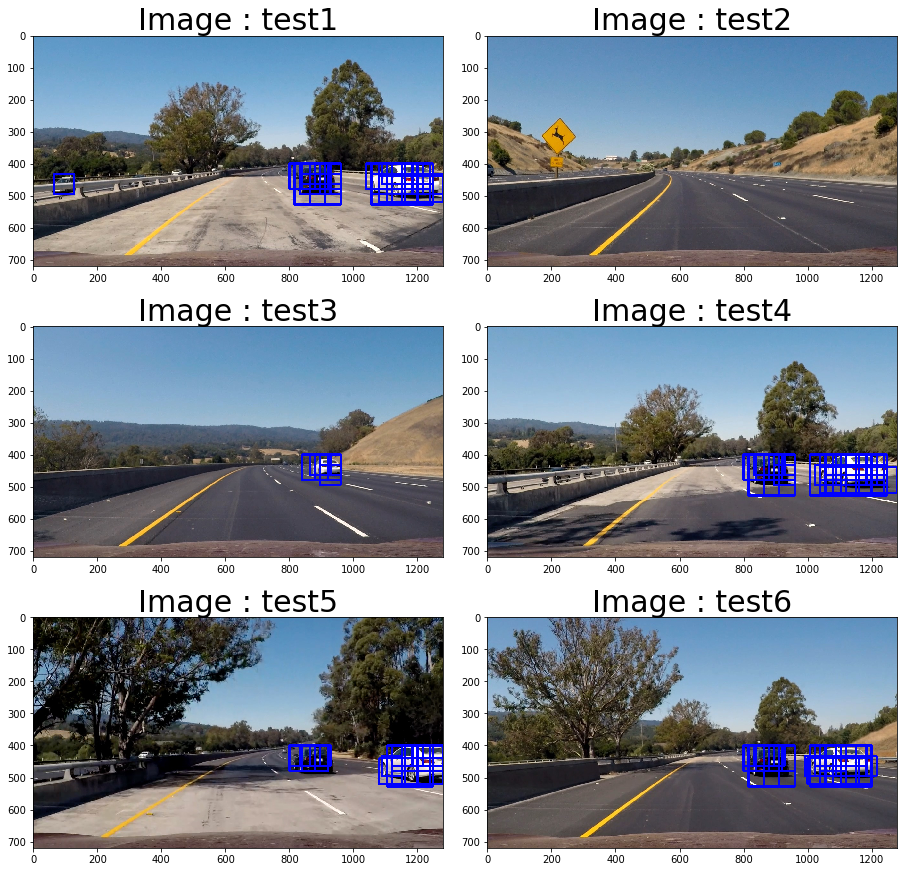

In [72]:
images = []
cmaps = []
for sample in img_hot_windows:
    cmaps.append('RdBu')
    images.append(draw_boxes(sample[0], sample[1]))

plot_images(images, titles, cmaps, len(test_images_path)//2 , 2)

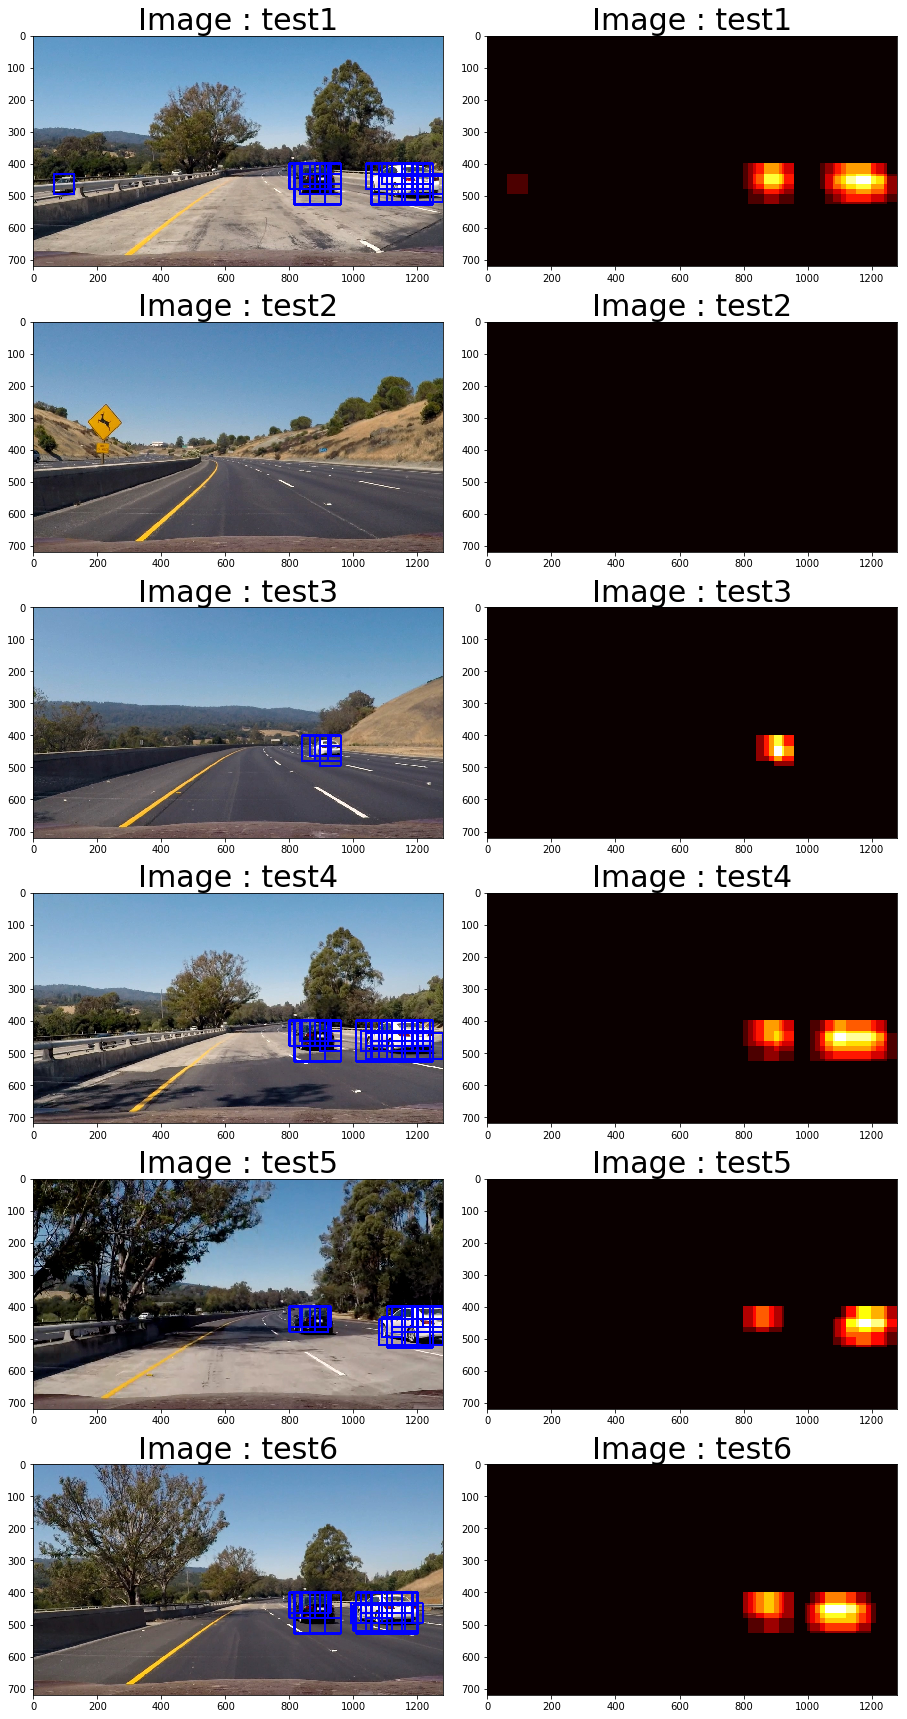

In [80]:
images = []
cmaps = []
image_titles = []
for sample, title in zip(img_hot_windows, titles):
    cmaps.append('RdBu')
    cmaps.append('hot')
    images.append(draw_boxes(sample[0], sample[1]))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,sample[1])
    images.append(heat)
    image_titles.append(title)
    image_titles.append(title)

plot_images(images, image_titles, cmaps, len(test_images_path) , 2)

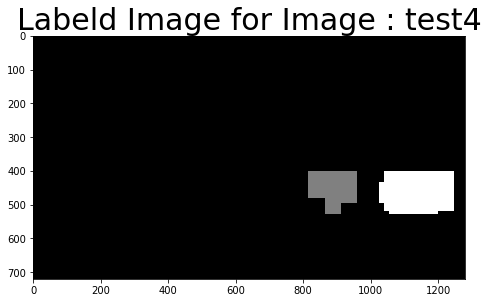

In [84]:
heat = apply_threshold(images[7],1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
plot_images(labels, ['Labeld Image for '+ image_titles[7]], ['gray'], 1 , 1)

Testing Time : 1.3679969310760498


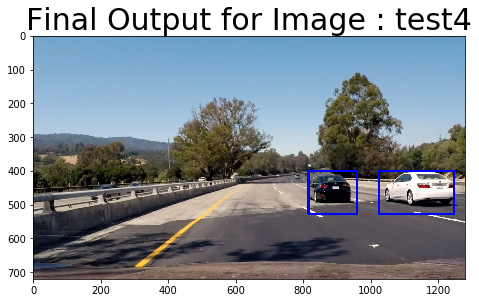

In [89]:
vehicleDetector = VehicleDetector()
image = mpimg.imread('test_images/test4.jpg')
t=time.time()
window_img = vehicleDetector.pipeline(image)
t2 = time.time()
print("Testing Time : {}".format(t2-t))
plot_images([window_img], ['Final Output for '+ image_titles[7]], ['RdBu'], 1 , 1)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicleDetector = VehicleDetector()

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(vehicleDetector.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:23<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 21min 26s
